# Classification (Loan Club Dataset)

We now move for regression to classification problems. We try to predict the "loan_status" ("Fully Paid", "Current", "Charged Off") based on other numerical and categorical features. We explore different classification models starting with a naive expansion of linear regression. We then use logistic regression which is a type of linear regression more suited for classification problems. We also apply Discriminant Analysis models (linear (LDA), quadratic (QDA))  which assume gaussian distribution of the data. Additionaly, we use K-nearest-neighbors non-parametric classifier and use k-fold cross-validation to choose the number of neighbors.

To overcome class imbalance issue, we compare the performance of these models on the test set using a confusion matrix and apply stratified train/test split. 

### Load libraries:

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copy
import time
from IPython.display import Markdown, display

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


# Reset all styles to the default:
plt.rcParams.update(plt.rcParamsDefault)
# Then make graphs inline:
%matplotlib inline

def displaybd(text):
    display(Markdown("**" + text + "**"))
    
import warnings
warnings.filterwarnings(action='once')

### Set Display Options

In [2]:
# Reset all styles to the default:
plt.rcParams.update(plt.rcParamsDefault)
# Then make graphs inline:
%matplotlib inline

# Useful function for Jupyter to display text in bold:
def displaybd(text):
    display(Markdown("**" + text + "**"))
    
# Set custom style settings:
# NB: We need to separate "matplotlib inline" call and these settings into different
# cells, otherwise the parameters are not set. This is a bug somewhere in Jupyter
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['lines.markersize'] = 10

## 1. Prepare The Data:

### Get and Clean the Data

A set of numerical features were selected to classify the loan_status. These 10 features were refined from a total of 52 numerical features without compromising the model performance. A preliminary model was fitted using the 52 features, and the features with dominant coefficients were selected.
A log transformation was performed on these features. In addition, we had include an engineered feature "loan_period", and a categorical feature "term".   

In [3]:
#-- LOAD DATA:

# Load sampled and cleaned loan club dataset
datetime_cols = ['issue_d','last_pymnt_d']
loan_club = pd.read_csv('Loan_sampled_cleaned.csv',parse_dates = datetime_cols)

loan_club['loan_period'] = loan_club['last_pymnt_d'] - loan_club['issue_d']
loan_club['loan_period'] = loan_club['loan_period'] / pd.to_timedelta(1, unit='D')


important_cols = ['loan_status','loan_amnt','term','int_rate','total_pymnt','loan_period',
                  'bc_util','percent_bc_gt_75','out_prncp','total_rec_int','recoveries']

loan_club = loan_club[important_cols]

# Select skewed regressors that should have log transformation. 
colsToLn = list(loan_club.select_dtypes(include=[np.number]).columns)
colsToLn.remove('loan_period')
colsToLn.remove('int_rate')
colsToLn.remove("percent_bc_gt_75")
colsToLn.remove("bc_util")



# Log transform
ln_cols = []
for colName in colsToLn:
    lnColName = "ln_" + colName
    loan_club[lnColName] = np.log(np.exp(1)+loan_club[colName])
    loan_club.drop([colName], axis=1,inplace = True)
    ln_cols.append(lnColName)


**The outcome variable has 7 unique values; however, we select only the 3 most common of them.**

In [4]:
classes = ['Charged Off','Current','Fully Paid']
loan_club = loan_club[loan_club['loan_status'].isin(classes)]
y = loan_club.loan_status
displaybd("Outcome [loan_status]:")
display(y.head())

**Outcome [loan_status]:**

0       Current
1    Fully Paid
2       Current
3    Fully Paid
4    Fully Paid
Name: loan_status, dtype: object

**We create our feature matrix by concatenating log-transformed features, and dummy catergorical feature.**

In [5]:
X = loan_club[ln_cols+['int_rate','percent_bc_gt_75','bc_util','loan_period']]

# Convert categorical variables into dummies:
dummies = pd.get_dummies(loan_club[['term']])
dummies.rename(columns={"term_ 36 months": "term_36_months"},inplace=True)
cat_features = ['term_36_months']
loan_club ['term_36_months'] = dummies['term_36_months']

# Extract predictors and outcome variables
X = pd.concat([X, dummies[cat_features]], axis=1)
feature_names = X.columns

displaybd("Predictors:")
display(X.describe())

**Predictors:**

,ln_loan_amnt,ln_total_pymnt,ln_out_prncp,ln_total_rec_int,ln_recoveries,int_rate,percent_bc_gt_75,bc_util,loan_period,term_36_months
count,72007.000000,72007.000000,72007.000000,72007.000000,72007.000000,72007.000000,72007.000000,72007.000000,72007.000000,72007.000000
mean,9.430437,9.008182,4.224446,7.251274,1.479226,13.205572,41.399165,57.233622,572.740067,0.701348
std,0.698352,1.006130,3.932764,1.157475,1.665373,4.882484,35.777918,28.399934,372.808859,0.457670
min,6.910470,4.151485,1.000000,1.000000,1.000000,5.310000,0.000000,0.000000,0.000000,0.000000
25%,8.987537,8.419225,1.000000,6.575269,1.000000,9.670000,0.000000,34.800000,273.000000,0.000000
50%,9.518025,9.158311,1.000000,7.337600,1.000000,12.690000,33.300000,59.200000,517.000000,1.000000
75%,9.903623,9.748179,8.784396,8.049774,1.000000,16.010000,66.700000,82.200000,853.000000,1.000000
max,10.596703,11.046282,10.583819,10.229560,10.224359,30.990000,100.000000,318.200000,2010.000000,1.000000


In [6]:
displaybd('Number of Observations: %s' % (X.shape[0]))
displaybd('Number of Predictors: %s' % (X.shape[1]))

**Number of Observations: 72007**

**Number of Predictors: 10**

We have a total of 72007 observations and 10 predictors.

### Split the data:
To validate our model performance on generalizing to unknown data, we need to to have some test subset for evaluating our model. We split our data into training and test subsets. Within the training data, we can use some validation subset to perform cross-validation for parameters tuning.  
We split the data into 1/2 for training, and 1/2 for testing, and apply some seed to reproduce the results. Due to imbalance of the outcome variable, we apply [Stratification](https://en.wikipedia.org/wiki/Stratified_sampling) to get a balanced split of the outcome between the train and test splits.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42,stratify = y)
displaybd("No. training samples: %s" % X_train.shape[0])
displaybd("No. testing samples: %s" % X_test.shape[0])

**No. training samples: 36003**

**No. testing samples: 36004**

We now have about 36,000 observation for training and test sets.

### Scaling the data:

Eventhough models like linear regression, logistic regression, LDA, and QDA don't require scaling, KNN requires scaling since it is distance based. We use scaled features throughout the notebook. Scaling can improve the model accuracy, and allow faster convergence. However, it makes linear model coefficients harder to interpret.

We use sklearn standard scaler.

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

To evaluate the model performance, we mainly use the accuracy as a metric. However, due to the imbalance of the data, accuracy might not be a fair metric since it might favor some dominant classes (i.e. "Fully Paid") over other non-dominant ones (i.e. "Charged Off").
Thus, we use confusion matrix to evaluate misclassified observation, and evaluate other metrics as precision, recall, and F1 score. 

In [9]:
def model_performance(model,X_test,y_test):
    y_pred = model.predict(X_test)
    confusionDF = pd.crosstab(y_pred, y_test,
                              rownames=['Predicted'], colnames=['Actual'],
                              margins=True)
    
    displaybd("Confusion matrix:")
    display(confusionDF)
    
    classificaton_rep = classification_report(y_test, y_pred)
    displaybd("Classification report:")
    print(classificaton_rep)

    accuracy = np.round(np.mean(y_test == y_pred),4)
    displaybd("Accuarcy: %s" % accuracy)
    

## [1] Linear Regression

Linear regression is most suited for regression problems; however, it can be extended to classification problems as well.
By encoding the outcome variable to a (0,1) value, we can fit a linear model to classify a binary outcome based on some threshold (i.e. 0.5).
\begin{equation}
  p(X) = Pr (Y = 1|X) = (\beta_0+\beta_1 * X) > 0.5 
\end{equation}

To classify an outcome with more than two classes ($n$), we fit need to fit $n$ models to distinct each class from all other classes ([One Vs. All](https://utkuufuk.com/2018/06/03/one-vs-all-classification/)).  

First, we need to use one hot encoding to get a binary feature for each class in our outcome. We use pandas "get_dummies".

In [10]:
y_train_one_hot = pd.get_dummies(y_train)
y_train_one_hot.head()

,Charged Off,Current,Fully Paid
55024,1,0,0
3695,0,0,1
22508,0,0,1
13516,0,0,1
36251,1,0,0


We fit $n$ linear regression models for each class. The predicted outcome is assigned to the class model with the largest regression value. We fit the model on the scaled train set, and evaluate it using the scaled test set.

In [11]:
def multi_linear_classifier(X_train,X_test,y_train_one_hot,classes):
    probas = []
    coeffs = []
    for _class in classes:
        LR = LinearRegression().fit(X_train,y_train_one_hot[_class])
        LR_proba = LR.predict(X_test_scaled)
        probas.append(LR_proba)
        coeffs.append(LR.coef_)
    probas = np.array(probas).T
    y_pred = np.argmax(probas,axis=1).astype(object)
    for i in range(len(classes)):
        y_pred[y_pred == i] = classes[i]
    coeffs = pd.DataFrame(np.array(coeffs).reshape((-1,len(classes))),index=feature_names, columns= classes)
    return y_pred,coeffs
y_pred, coeffs = multi_linear_classifier(X_train_scaled,X_test_scaled,y_train_one_hot,classes)
displaybd("Predictions:")
display(y_pred[:10])

**Predictions:**

array(['Fully Paid', 'Current', 'Current', 'Fully Paid', 'Current',
       'Fully Paid', 'Charged Off', 'Current', 'Fully Paid', 'Fully Paid'],
      dtype=object)

We fit three linear models with the following coefficients (There is no clear interpretation of the coefficients in this case).

In [12]:
displaybd("Linear Regression Coefficients:")
display(coeffs)

**Linear Regression Coefficients:**

,Charged Off,Current,Fully Paid
ln_loan_amnt,0.093667,-0.207763,-0.143131
ln_total_pymnt,0.092324,0.202513,0.000042
ln_out_prncp,0.002716,-0.005681,0.010667
ln_total_rec_int,0.006988,-0.054864,0.039544
ln_recoveries,0.513581,-0.019847,0.011026
int_rate,0.005716,-0.001095,-0.000494
percent_bc_gt_75,0.024038,0.006901,-0.038804
bc_util,0.168219,-0.370450,-0.072477
loan_period,-0.213539,-0.005758,-0.001620
term_36_months,0.006175,-0.034705,-0.013889


We can see some features are more significant (higher absolute coefficient values) than others. For example, ln_loan_amount has high coefficient than int_rate. 

We can use the predicted outcome from the test set ($y_{predicted}$) and compare it to the ground truth values ($y_{test}$).

In [13]:
confusionDF = pd.crosstab(y_pred, y_test,
                          rownames=['Predicted'], colnames=['Actual'],
                          margins=True)

displaybd("Confusion matrix:")
display(confusionDF)

classificaton_rep = classification_report(y_test, y_pred)
displaybd("Classification report:")
print(classificaton_rep)

accuracy_linear = np.round(np.mean(y_test == y_pred),4)
displaybd("Accuarcy: %s" % accuracy_linear)

**Confusion matrix:**

Actual,Charged Off,Current,Fully Paid,All
Predicted,,,,
Charged Off,2847,0,0,2847
Current,0,14695,0,14695
Fully Paid,1391,127,16944,18462
All,4238,14822,16944,36004


**Classification report:**

              precision    recall  f1-score   support

 Charged Off       1.00      0.67      0.80      4238
     Current       1.00      0.99      1.00     14822
  Fully Paid       0.92      1.00      0.96     16944

    accuracy                           0.96     36004
   macro avg       0.97      0.89      0.92     36004
weighted avg       0.96      0.96      0.95     36004



**Accuarcy: 0.9578**

The linear model is unexpectedly accurate with accuracy around 96%. Most of the error of the model can be assossiated with misclassifying many "Charged Off" as "Fully Paid". Due to the relatively few "Charged Off" observations, the accuracy didn't suffer much. However, the "Charged Off" recall is relatively low (0.67). It is hard to seperate the two classes ("Charged Off" , "Fully Paid") perfectly with linear regression since each model outputs unbounded values, which might favor one class over the other. Next, we try logistic regression, which outputs a problablity of the class between 0 and 1.   

## [2] Logistic Regression

Logistic regression is an expansion of linear regression to suit the nature of classification problems. It applies a logistic function to bound the output between 0 and 1. The output can then represent the class probablity. 
\begin{equation}
  p(X) = Pr (Y = 1|X) = {e^{\beta_0+\beta_1 * X} \over (1+e^{\beta_0+\beta_1 * X})}
\end{equation}

Logistic regression works on binary classification problems, so problems with more than two classes requires fitting more logistic regression models. 

sklearn "[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)" method inherently solves multiclass prolbems by fitting more model internally. 

In [14]:
logit_model = LogisticRegression(multi_class = 'multinomial',solver = 'newton-cg') #ovr
start_time = time.time()
logit_model.fit(X_train_scaled, y_train)

model_coeff = pd.DataFrame(np.abs(logit_model.coef_.T),columns=logit_model.classes_, index = feature_names)
displaybd("Coefficients:")
display(model_coeff)

**Coefficients:**

,Charged Off,Current,Fully Paid
ln_loan_amnt,4.450168,1.497489,5.947656
ln_total_pymnt,9.617509,0.888625,10.506134
ln_out_prncp,3.967886,7.520069,3.552182
ln_total_rec_int,3.704761,1.616463,2.088298
ln_recoveries,2.796144,0.978456,1.817688
int_rate,0.418437,0.388994,0.029443
percent_bc_gt_75,0.011141,0.036409,0.025269
bc_util,0.007150,0.120487,0.127637
loan_period,0.160924,0.439972,0.600895
term_36_months,0.299417,0.219393,0.080024


Similiar to linear regression coefficients, some features are more influential. For logestic regression, the coefficients are on a different scale. We can also note that feature importance varies from one classifer to another. For example, for "Charged Off", and "Fully Paid" classifiers, ln_total_pymnt is the most important feature; while, for "Current" classifier, ln_out_prncp is a more important feature.  

Let's evaluate the logistic model performance on the test set. 

In [15]:
model_performance(logit_model,X_test_scaled,y_test)

**Confusion matrix:**

Actual,Charged Off,Current,Fully Paid,All
Predicted,,,,
Charged Off,4152,0,0,4152
Current,0,14705,0,14705
Fully Paid,86,117,16944,17147
All,4238,14822,16944,36004


**Classification report:**

              precision    recall  f1-score   support

 Charged Off       1.00      0.98      0.99      4238
     Current       1.00      0.99      1.00     14822
  Fully Paid       0.99      1.00      0.99     16944

    accuracy                           0.99     36004
   macro avg       1.00      0.99      0.99     36004
weighted avg       0.99      0.99      0.99     36004



**Accuarcy: 0.9944**

The logistic model could overcome the shortcomings of linear model for correctly classifying the "Charged Off" observations. The accuracy is now about 99.4% with nearly perfect precision and recall for all classes. We can see that the model is slightly biased towards "Fully Paid" so it get a perfect recall (correctly classify all fully-paid obsevations), but a nearly-perfect precision (misclassifies the other two classes (charged-off, current) as fully-paid).  
The model performance suggest that the classes are linearly seperable. If that was not the case, we would need to explore other classifiers that can fit non linear boundries like LDA and QDA.

## [3] Linear Discriminant Analysis

Linear Discriminant Analysis start with an assumption of a multivariate gaussian distibution of each class. We assume each class has a specific mean vector $μ_k$ , but all classes share a common covariance matrix $\Sigma$. We can then estimate the following probablity of each class $\gamma_k$. The assigned class is the one with highest $\gamma_k$. 

\begin{equation}
  \gamma_k(x) = x^T\Sigma^{-1}μ_k −{1\over2} μ_k^T\Sigma^{-1}μ_k + log\ \pi_k
\end{equation}


sklearn "[LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)" is used to fit the LDA model. Unlike logistic and linear classifiers, only a single classifier is required for multiclass classification.

We use the following functions to display the different classes, prior probablities, means, and coefficients of the linear boundaries.

In [16]:
def printPriorProbabilities(ldaClasses, ldaPriors):
    priorsDF = pd.DataFrame()
    for cIdx, cName in enumerate(ldaClasses):
        priorsDF[cName] = [ldaPriors[cIdx]];
    displaybd('Prior probablities of groups:')
    display(Markdown(priorsDF.to_html(index=False)))
    
def printGroupMeans(ldaClasses, featuresNames, ldaGroupMeans):
    displaybd("Group means:")
    groupMeansDF = pd.DataFrame(index=ldaClasses)
    for fIdx, fName in enumerate(featuresNames):
         groupMeansDF[fName] = ldaGroupMeans[:, fIdx]
    display(groupMeansDF)

def printLDACoeffs(featuresNames,classes, ldaCoeffs):
    coeffDF = pd.DataFrame(index=featuresNames)
    for cIdx in range(ldaCoeffs.shape[0]):
        colName = classes[cIdx] 
        coeffDF[colName] = ldaCoeffs[cIdx]
    displaybd("Coefficients of linear discriminants:")
    display(coeffDF)


Let's fit our model.

In [17]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train);

printPriorProbabilities(lda.classes_, lda.priors_)
printGroupMeans(lda.classes_, feature_names, lda.means_)
printLDACoeffs(feature_names,lda.classes_, lda.coef_)

**Prior probablities of groups:**

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Charged Off</th>
      <th>Current</th>
      <th>Fully Paid</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.11774</td>
      <td>0.41166</td>
      <td>0.4706</td>
    </tr>
  </tbody>
</table>

**Group means:**

,ln_loan_amnt,ln_total_pymnt,ln_out_prncp,ln_total_rec_int,ln_recoveries,int_rate,percent_bc_gt_75,bc_util,loan_period,term_36_months
Charged Off,0.129136,-0.243574,-0.820166,0.227055,2.159862,0.561770,0.251372,0.222359,-0.219018,-0.268152
Current,0.053374,-0.506098,1.172171,-0.030547,-0.288240,-0.070655,-0.118313,-0.116475,-0.141622,-0.138569
Fully Paid,-0.078998,0.503653,-0.820166,-0.030086,-0.288240,-0.078744,0.040604,0.046255,0.178682,0.188304


**Coefficients of linear discriminants:**

,Charged Off,Current,Fully Paid
ln_loan_amnt,6.806216,-5.612304,3.206540
ln_total_pymnt,-9.561317,5.172050,-2.132121
ln_out_prncp,-39.358058,46.641662,-30.953034
ln_total_rec_int,4.402067,-2.499813,1.085367
ln_recoveries,5.979513,-0.650558,-0.926946
int_rate,-0.383737,0.505937,-0.346563
percent_bc_gt_75,0.163967,-0.118851,0.062943
bc_util,-0.155336,0.001933,0.037173
loan_period,-1.265709,2.043551,-1.470940
term_36_months,-0.233079,0.555164,-0.427319


The prior probablities ($\pi_k$) is estimated from the y_train as how common is one class relative to other. "Fully Paid" class is the most common one.

The class feature means are relatively different; suggesting that it would be possible to seperate classes. 

We can also see from the class coefficients that some features are highly significant like ln_out_prncp.

In [18]:
model_performance(lda,X_test_scaled,y_test)

**Confusion matrix:**

Actual,Charged Off,Current,Fully Paid,All
Predicted,,,,
Charged Off,2997,0,0,2997
Current,0,14699,0,14699
Fully Paid,1241,123,16944,18308
All,4238,14822,16944,36004


**Classification report:**

              precision    recall  f1-score   support

 Charged Off       1.00      0.71      0.83      4238
     Current       1.00      0.99      1.00     14822
  Fully Paid       0.93      1.00      0.96     16944

    accuracy                           0.96     36004
   macro avg       0.98      0.90      0.93     36004
weighted avg       0.96      0.96      0.96     36004



**Accuarcy: 0.9621**

LDA's performance is not as good as logistic regression. This is due to linear seperablity of the data, and the imperfect assumption of gaussian distribution. However, LDA has a slightly better performance compared to linear regression. Similiar to linear regression, "Charged Off" class has a low recall due to the bias towards "Fully Paid" class.

We can check the confidence in our predictions through checking the postrior probablities of each class.

In [19]:
pred_p = lda.predict_proba(X_test_scaled)
# pred_p is an array of shape (number of observations) x (number of classes)
pred_p = pd.DataFrame(pred_p,columns=lda.classes_)
displaybd("Posterior Probablities with 0.5 threshold:")
display((pred_p > 0.5).mean(axis=0))

displaybd("Posterior Probablities with 0.9 threshold:")
display((pred_p > 0.9).mean())

**Posterior Probablities with 0.5 threshold:**

Charged Off    0.083241
Current        0.408260
Fully Paid     0.508499
dtype: float64

**Posterior Probablities with 0.9 threshold:**

Charged Off    0.080241
Current        0.408121
Fully Paid     0.504416
dtype: float64

Changing the threshold from 0.5 to 0.9 resulted in very slight change. This suggests that the classes are assigned with high confidence. 

## [4] Quadratic Discriminant Analysis

Quadratic Discriminant Analysis is an expansion of Linear Discriminant Analysis. It can give a more flexible model by assuming each class has a distinct covariance matrix $\Sigma_k$. This would make the class probablity $\gamma_k$ nonlinear (quadratic) with feature $x$.

\begin{equation}
  \gamma_k(x) = -{1\over2}(x -μ_k)^T \Sigma_k^{-1}(x -μ_k) − {1\over2}{log\ |\Sigma_k|} + log\ \pi_k
\end{equation}

This would increase model flexiblity for nonlinear decision boundaries. QDA can be more computationally expensive than LDA as computes more parameters.

sklearn "[QuadraticDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis)" is used to fit the model.

In [20]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train);
printPriorProbabilities(qda.classes_, qda.priors_)
printGroupMeans(qda.classes_, feature_names, qda.means_)


C:\Users\ammus\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


**Prior probablities of groups:**

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Charged Off</th>
      <th>Current</th>
      <th>Fully Paid</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.11774</td>
      <td>0.41166</td>
      <td>0.4706</td>
    </tr>
  </tbody>
</table>

**Group means:**

,ln_loan_amnt,ln_total_pymnt,ln_out_prncp,ln_total_rec_int,ln_recoveries,int_rate,percent_bc_gt_75,bc_util,loan_period,term_36_months
Charged Off,0.129136,-0.243574,-0.820166,0.227055,2.159862,0.561770,0.251372,0.222359,-0.219018,-0.268152
Current,0.053374,-0.506098,1.172171,-0.030547,-0.288240,-0.070655,-0.118313,-0.116475,-0.141622,-0.138569
Fully Paid,-0.078998,0.503653,-0.820166,-0.030086,-0.288240,-0.078744,0.040604,0.046255,0.178682,0.188304


The class means and priors are the same for LDA and QDA. The main difference would the covariance matrix.

Let's evaluate the model on the test set.

In [21]:
model_performance(qda,X_test_scaled,y_test)

**Confusion matrix:**

Actual,Charged Off,Current,Fully Paid,All
Predicted,,,,
Charged Off,4200,0,52,4252
Current,0,14728,0,14728
Fully Paid,38,94,16892,17024
All,4238,14822,16944,36004


**Classification report:**

              precision    recall  f1-score   support

 Charged Off       0.99      0.99      0.99      4238
     Current       1.00      0.99      1.00     14822
  Fully Paid       0.99      1.00      0.99     16944

    accuracy                           0.99     36004
   macro avg       0.99      0.99      0.99     36004
weighted avg       0.99      0.99      0.99     36004



**Accuarcy: 0.9949**

QDA has almost the same perfect performance as for logistic regression. This performance is superior to LDA.

## [5] k-Nearest Neighbors

K-Nearest Neighbors classifier is a non-parametric classifier wih no assumptions on the decision boundary. A class is assigned according to dominant class of the k nearest neighbors. KNN uses a distance metric to find nearest neighbors, and the performance depends on the choice of this metric. It also requires the pairwise distances between all observations, so it would be relatively slow. Eventhough, it can offer powerful classification model, it gives very little understanding of the model.

To choose the number of nearest neighbors $k$, we use a 10-fold cross-validation on the training set. The accuracy is chosen as the metric to evaluate the models. We create a pipeline to scale the features before applying KNN.

sklearn "[KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)" is used to fit KNN model.

In [22]:
knn = KNeighborsClassifier(n_jobs = -1)
neighbors = np.linspace(1, 30, 30).astype(int)
params = {'knn__n_neighbors': neighbors}
pipe = Pipeline(steps=[('scale', scaler), ('knn', knn)])
knn_clf = GridSearchCV(pipe, params, cv=10,scoring='accuracy')
knn_clf.fit(X_train, y_train);

Let's find the best $k$

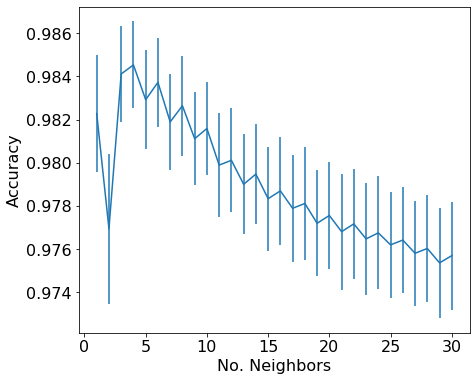

In [23]:
plt.errorbar(neighbors,knn_clf.cv_results_['mean_test_score'],knn_clf.cv_results_['std_test_score'])
plt.xlabel('No. Neighbors')
plt.ylabel('Accuracy');

Most values of $k$ gives a relatively good performance with accuracy over 97%. However, the accuracy peaks for $k=4$. We can then use it to fit our best KNN classifier using the full training set.

In [29]:
print("Best No. Neighbors: ", knn_clf.best_params_)
print("Best KNN Accuracy: ", knn_clf.best_score_)
knn_best = KNeighborsClassifier(n_neighbors =  knn_clf.best_params_['knn__n_neighbors'])
knn_best.fit(X_train_scaled,y_train);

Best No. Neighbors:  {'knn__n_neighbors': 4}
Best KNN Accuracy:  0.9845290670221926


Let's evaluate the model performance on the test set.

In [25]:
model_performance(knn_best,X_test_scaled,y_test)

**Confusion matrix:**

Actual,Charged Off,Current,Fully Paid,All
Predicted,,,,
Charged Off,3892,0,36,3928
Current,3,14694,9,14706
Fully Paid,343,128,16899,17370
All,4238,14822,16944,36004


**Classification report:**

              precision    recall  f1-score   support

 Charged Off       0.99      0.92      0.95      4238
     Current       1.00      0.99      1.00     14822
  Fully Paid       0.97      1.00      0.98     16944

    accuracy                           0.99     36004
   macro avg       0.99      0.97      0.98     36004
weighted avg       0.99      0.99      0.99     36004



**Accuarcy: 0.9856**

The performance is an improvement over linear regression, and LDA. However, it is not as good as logistic regression. This might confirm our guess that the decision boundaries might be linear; thus, logit has a better performance. 

## [6] Compare Models

Finally, we compare all the models based on thier accuracy and the execution time. We run the models using different train/test splits. We then scale the data, fit the models, and estimate the accuracy and run time.

In [26]:
warnings.filterwarnings('ignore')

models = [logit_model, lda, qda, knn_best]
model_accuracy = []
exec_time = []
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    y_train_one_hot = pd.get_dummies(y_train)
    start_time = time.time()
    y_pred,_ = multi_linear_classifier(X_train_scaled,X_test_scaled,y_train_one_hot,classes)
    time_linear = time.time() - start_time
    accuracy_linear = np.round(np.mean(y_test == y_pred),4)
    exec_time.append(time_linear)
    model_accuracy.append(accuracy_linear)
    
    for model in models:
        start_time = time.time()
        model.fit(X_train_scaled,y_train);
        time_ = time.time() - start_time
        exec_time.append(time_)
        
        y_pred = model.predict(X_test_scaled)
        accuracy_ = np.round(np.mean(y_test == y_pred),4)
        model_accuracy.append(accuracy_)

### Models Accuracy

**Model Accuracy:**

,Linear,Logistic,LDA,QDA,KNN
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.958122,0.994548,0.962288,0.834886,0.985392
std,0.000867,0.000374,0.000955,0.166787,0.000599
min,0.955900,0.993600,0.959700,0.528900,0.983800
25%,0.957500,0.994300,0.961600,0.700900,0.985025
50%,0.958050,0.994500,0.962200,0.893550,0.985350
75%,0.958600,0.994875,0.962875,0.993950,0.985700
max,0.960200,0.995300,0.964600,0.996100,0.987000


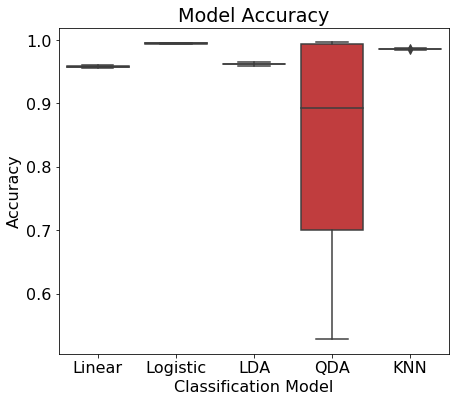

In [27]:
model_names = ["Linear", "Logistic", "LDA", "QDA", "KNN"]

accuracy_df = pd.DataFrame(np.array(model_accuracy).reshape((-1,5)), columns= model_names)
displaybd("Model Accuracy:")
display(accuracy_df.describe())
sns.boxplot(data = accuracy_df)
plt.xlabel("Classification Model");
plt.ylabel("Accuracy");
plt.title("Model Accuracy");

All models except for QDA are stable, and has high accuracy. Logistic regression has the highest accuracy and linear regression might be the lowest one.

QDA, however, is highly unstable, and is highly dependant on the train/test split. QDA accuracy can sometimes exceed the logistic regression accuracy, and other times would be as low as 52%. The reason for this is unknown to me yet. One reason might be the variables collinearlity; however, VIFs were estimated to be less than 10 for all features. 

**Execution Time:**

,Linear,Logistic,LDA,QDA,KNN
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.041573,2.240412,0.321544,0.147609,0.469026
std,0.006218,0.181665,0.026166,0.022395,0.174142
min,0.031975,1.966686,0.271820,0.119880,0.271861
25%,0.039937,2.128609,0.303835,0.127917,0.353805
50%,0.039974,2.214498,0.311796,0.143903,0.430243
75%,0.047967,2.321165,0.327788,0.159892,0.488086
max,0.055969,2.854001,0.411795,0.207865,0.935372


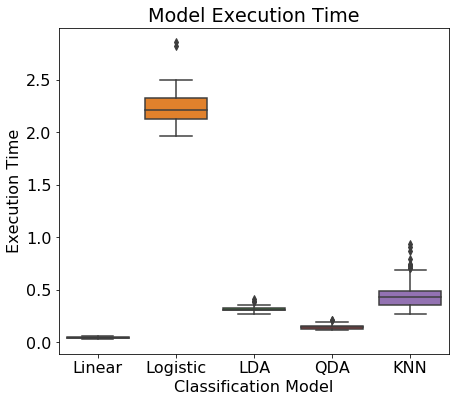

In [28]:
time_df = pd.DataFrame(np.array(exec_time).reshape((-1,5)), columns= model_names)
displaybd("Execution Time:")
display(time_df.describe())
plt.figure()
sns.boxplot(data = time_df)
plt.xlabel("Classification Model");
plt.ylabel("Execution Time");
plt.title("Model Execution Time");

Linear regression executes the fastest. Logistic regression takes long time to fit. Maybe, the choice of the solver "newton-cg" is not appropiate, so it takes time to converage. It was expected that QDA would require more time to fit the model compared to LDA, as it fits more paramaters. This might point so problem with thr QDA implementation. As expected, KNN requires the longest time to execute.  